In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson
import numpy as np
from urllib.request import urlretrieve
import os

In [29]:
los_angeles_filename = "Los angeles 2020-Present.csv"

# if the data is not already downloaded, download it
if not os.path.exists(los_angeles_filename):
    url = "https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD"
    urlretrieve(url, los_angeles_filename)
else:
    print(f"{los_angeles_filename} already exists, skipping download")

data.csv already exists, skipping download


In [30]:
config = {
    "Los Angeles": {
        "filename": los_angeles_filename,
        "date_column": "DATE OCC",
        "area_column": "AREA",
        "extract_day": True,
    }
}

state = "Los Angeles"

conf = config[state]

In [31]:
df = pd.read_csv(conf['filename'], usecols=[conf['date_column'], conf['area_column']]);
df = df.dropna()

In [32]:
df.head()

,DATE OCC,AREA
0,03/01/2020 12:00:00 AM,7
1,02/08/2020 12:00:00 AM,1
2,11/04/2020 12:00:00 AM,3
3,03/10/2020 12:00:00 AM,9
4,08/17/2020 12:00:00 AM,6


In [33]:
print(f"Number of areas: {df[conf['area_column']].nunique()}")

Number of areas: 21


In [34]:
### Convert data column to datetime and retain only day component
if conf['extract_day']:
    print(df[conf['date_column']].dtypes)

    df[conf['date_column']] = pd.to_datetime(df[conf['date_column']]).dt.strftime('%Y-%m-%d')  #, format="%Y-%m-%d") #, errors='coerce')
    df[conf['date_column']].head()

object


C:\Users\merli\AppData\Local\Temp\ipykernel_25968\4133788686.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[conf['date_column']] = pd.to_datetime(df[conf['date_column']]).dt.strftime('%Y-%m-%d')  #, format="%Y-%m-%d") #, errors='coerce')


In [35]:
df.head()

,DATE OCC,AREA
0,2020-03-01,7
1,2020-02-08,1
2,2020-11-04,3
3,2020-03-10,9
4,2020-08-17,6


Lambda: 39.673444239063464 for area 1, on the basis of 64390 crimes.
L1 distance: 0.6545
L-inf distance: 0.035

Lambda: 27.277264325323475 for area 2, on the basis of 44271 crimes.
L1 distance: 0.3257
L-inf distance: 0.0234

Lambda: 33.224892174984596 for area 3, on the basis of 53924 crimes.
L1 distance: 0.3623
L-inf distance: 0.0274

Lambda: 21.579174368453483 for area 4, on the basis of 35023 crimes.
L1 distance: 0.2549
L-inf distance: 0.0213

Lambda: 24.242760320394332 for area 5, on the basis of 39346 crimes.
L1 distance: 0.2283
L-inf distance: 0.0207

Lambda: 30.71780653111522 for area 6, on the basis of 49855 crimes.
L1 distance: 0.3693
L-inf distance: 0.0258

Lambda: 28.06223043746149 for area 7, on the basis of 45545 crimes.
L1 distance: 0.3463
L-inf distance: 0.0231

Lambda: 26.714725816389404 for area 8, on the basis of 43358 crimes.
L1 distance: 0.2732
L-inf distance: 0.0222

Lambda: 25.046210720887245 for area 9, on the basis of 40650 crimes.
L1 distance: 0.2159
L-inf dist

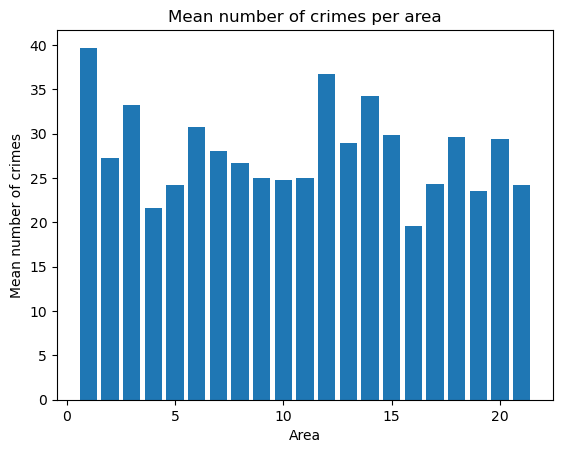

In [36]:
areas = []
lambdas = []

# Iterate over areas in the dataframe
for area in sorted(list(df[conf['area_column']].unique())):

    # Filter the dataframe for the current area
    area_df = df.loc[df[conf['area_column']] == area].copy()

    # Skip areas with less than 50 crimes
    num_crimes = len(area_df)
    if num_crimes < 50:
        print(f"Area {area} has less than 50 crimes. Skipping...")
        continue

    # Group by date and count the number of crimes of each day
    area_df = area_df.groupby(conf['date_column']).size().reset_index(name='count')

    # Calculate the mean number of crimes per day
    lambda_ = area_df['count'].mean()
    print(f"Lambda: {lambda_} for area {area}, on the basis of {num_crimes} crimes.")

    # validation -> l1 and l-inf distance between the empirical distribution and the poisson distribution
    empirical_dist = area_df['count'].value_counts(normalize=True)
    poisson_dist = poisson.pmf(empirical_dist.index, lambda_)

    l1 = sum(abs(empirical_dist - poisson_dist))
    linf = max(abs(empirical_dist - poisson_dist))

    print(f"L1 distance: {round(l1, 4)}")
    print(f"L-inf distance: {round(linf, 4)}\n")

    areas.append(area)
    lambdas.append(lambda_)

print(f"Lambdas: {[round(l, 2) for l in lambdas]}")

# Plot bar plot
plt.bar(areas, lambdas)
plt.xlabel('Area')
plt.ylabel('Mean number of crimes')
plt.title('Mean number of crimes per area')
plt.show()